# Laboratory work 3
## Variant 3 (27)
<b>NN architecture:</b> WideResNet28-10 <br/>
<b>Optimizer:</b> SGD <br/>
<b>Semi-supervised algorithm:</b> Co-Training <br/>
<b>Dataset:</b> Cifar10 <br/>
<b>link to dataset:</b> https://www.cs.toronto.edu/~kriz/cifar.html

# The CIFAR-10 dataset
The <b>CIFAR-10</b> dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Imports

In [1]:
!pip3 install advertorch==0.1.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 13.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for advertorch: filename=advertorch-0.1.5-py3-none-any.whl size=5314076 sha256=1ca34658f8b00e98029ede902ea46be62bddb8061293167bb53a1cefc241bed0
  Stored in directory: /root/.cache/pip/wheels/a0/ac/7d/dae1865ba5145ad3a8cae4278ac59d36386e428a4739df4ce6
Successfully built advertorch


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchmetrics
import random
import math
import os
import gc

from tqdm import tqdm
from torch.autograd import Variable
from sklearn.model_selection import StratifiedKFold, train_test_split
from advertorch.attacks import GradientSignAttack

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Reproducibility

In [4]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(0)
g_train_S = torch.Generator().manual_seed(1)
g_train_U = torch.Generator().manual_seed(2)
g_test = torch.Generator().manual_seed(3)

In [5]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)
RAND_CONST = 10

# Data read
This dataset already has train and test split (0.833 - 50000 to 0.167 - 10000). Let's further split it into:
```
1. train labeled set (30%)     25%       15000 images
2. train unlabeled set (70%)   58.33%    35000 images
3. test set                    16.67%    10000 images
Total images used for sets: 60000
```

In [6]:
train_labeled_len = 15000
valid_unlabeled_len = 35000
test_len = 10000

## Define transformers for data

In [7]:
# Calculate mean and std of test and train sets (255 - possible pixel value range)
traindata = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True).data / 255
testdata = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True).data / 255
mean_trn = traindata.mean(axis = (0,1,2)) 
std_trn = traindata.std(axis = (0,1,2))
mean_tst = testdata.mean(axis = (0,1,2)) 
std_tst = testdata.std(axis = (0,1,2))


# Create sequence of transformations: data ->  (translation at most two pixels for training data)
#            -> (random horizontal flip for training data) -> tensor -> (tensor - mean) / std

transform_train = transforms.Compose([
    transforms.RandomAffine(0, translate=(1/16,1/16)), # translation at most two pixels
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_trn, std_trn),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tst, std_tst),
])

# Number of images in each batch, recommended to == 2^n
batch_size = 32

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Clear memory
del traindata
del testdata
gc.collect()

100%|██████████| 170498071/170498071 [00:04<00:00, 35227237.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


0

## Creating dataloaders for train, validation and test datasets

In [8]:
# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)

labels = trainset.targets

# Perform stratified random split into labeled training (30%) and unlabeled training (70%) sets
train_labeled_ind, train_unlabeled_ind = train_test_split(
    list(range(len(trainset))), test_size=0.7, random_state=RAND_CONST, stratify=labels)

# Create labeled and unlabeled train datasets (used in DeepCoTraining)
train_labeled_dataset = torch.utils.data.Subset(trainset, train_labeled_ind)
train_unlabeled_dataset = torch.utils.data.Subset(trainset, train_unlabeled_ind)

# Create a sampler, that provides an iterable over train dataset (used in OrdinaryTraining)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0,
    worker_init_fn=seed_worker, generator=g_train)

# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)

# Create a sampler for testset (used in OrdinaryTraining)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0,
    worker_init_fn=seed_worker, generator=g_test)

## Data visualization

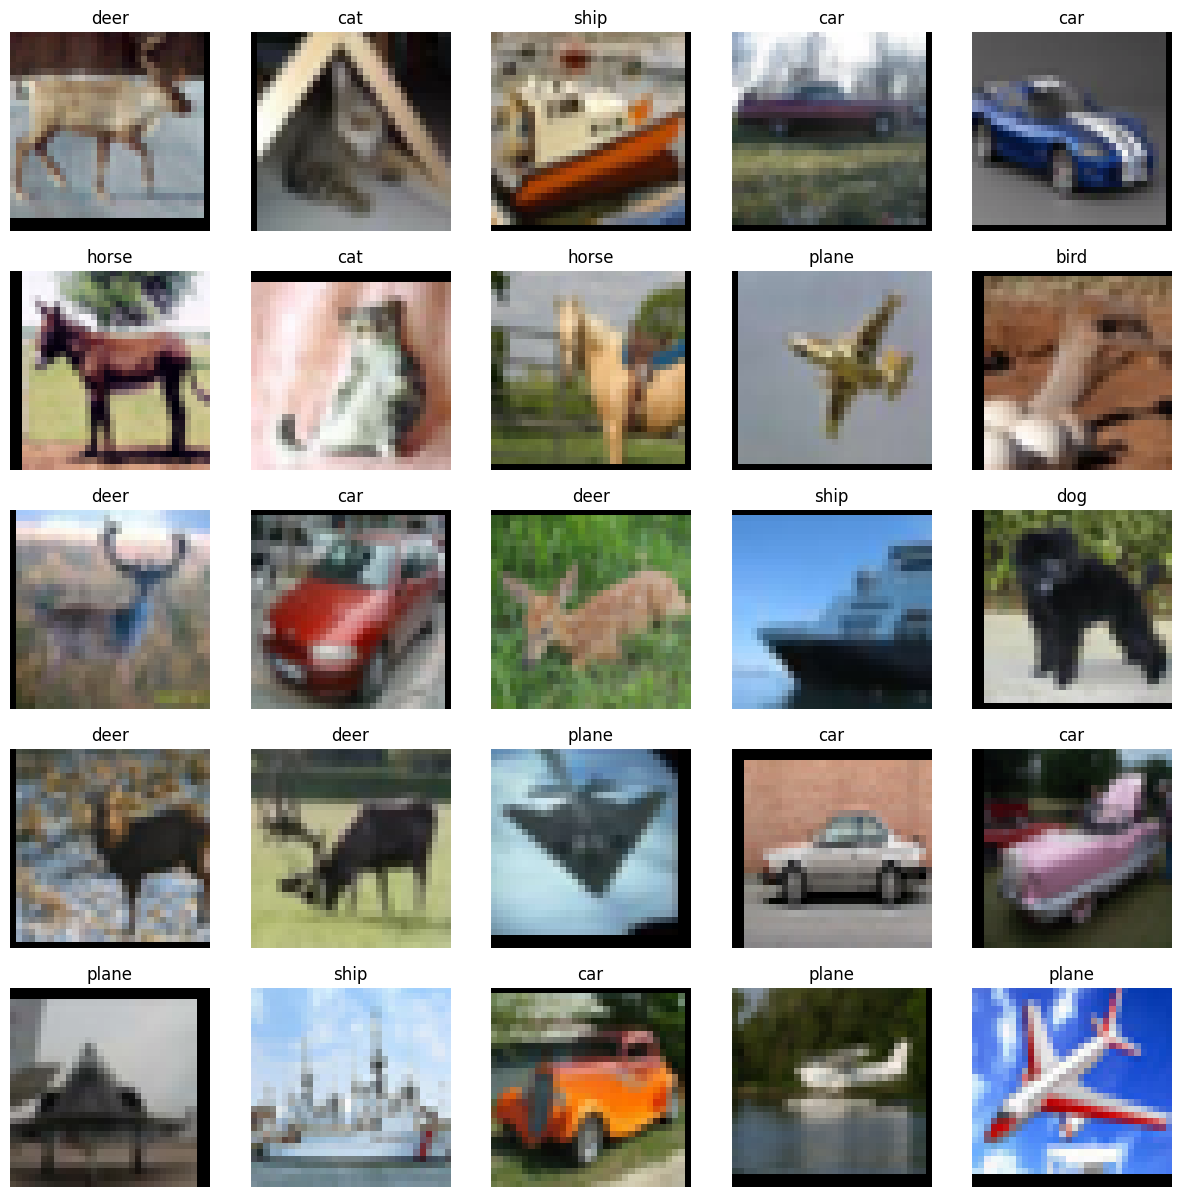

In [9]:
def imshow(img):
    # Unnormalize image
    img = img * std_trn[:, None, None] + mean_trn[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images and labels in a grid 5x5
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(0, rows * cols):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i + 1)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

In [10]:
# Set up loss criterion (used in OrdinaryTraining)
criterion = nn.CrossEntropyLoss()
# Set up and send to GPU accuracy metric
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to(device)
print(f"Amount of batches processed in each epoch during full ordinary training: {len(train_loader)}")

Amount of batches processed in each epoch during full ordinary training: 1562


## Class, that creates abstraction for model, dataloaders, optimizer, criterion, etc., and allows to train, validate and test this model

In [11]:
class OrdinaryTraining:
    def __init__(self, model, optimizer, criterion, accuracy, train_loader, test_loader, device, checkpoint_dir=None):
        """
        Parameters
        ----------
        model :
            CNN architecture model, already created and sent to device
        optimizer :
            Already instantiated optimizer
        criterion :
            Already instantiated criterion
        accuracy :
            Already instantiated accuracy
        train_loader :
            Batch loader of train data
        test_loader :
            Batch loader of test data
        device :
            Device where data will be sent to (for example cuda)
        checkpoint_dir : optional
            Path to directory where checkpoint state lies
        """
        
        self.optimizer = optimizer
        self.criterion = criterion
        self.accuracy = accuracy
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.train_batches_num = len(train_loader)
        self.test_batches_num = len(test_loader)
        self.model = model
        self.arr_loaded = False # whether we loaded loss and accuracy arrays
        
        # Load training model from checkpoint
        if checkpoint_dir is not None:
            print("Loading OrdinaryTraining model from checkpoint...")
            checkpoint = torch.load(checkpoint_dir)
            te = checkpoint['total_epochs']
            self.model.load_state_dict(checkpoint['model_param'])
            self.start_epoch = checkpoint['current_epoch'] + 1
            self.best_accuracy = checkpoint['best_accuracy']
            
            # Load loss and accuracy arrays
            fill_array = np.zeros(int(te - self.start_epoch))
            self.train_loss_arr = np.concatenate((checkpoint['train_loss_arr'][:self.start_epoch], fill_array))
            self.val_loss_arr = np.concatenate((checkpoint['val_loss_arr'][:self.start_epoch], fill_array))
            self.val_accuracy_arr = np.concatenate((checkpoint['val_accuracy_arr'][:self.start_epoch], fill_array))
            self.arr_loaded = True
            
            # Load environment state
            torch.set_rng_state(checkpoint['rng_state'])
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
            np.random.set_state(checkpoint['np_random_state'])
            random.setstate(checkpoint['random_state'])
            print(f"!This checkpoint was supposed to train for {te} epochs, "
                  f"current start_epoch={self.start_epoch + 1}!")
        # Create blank training model
        else:
            print("Creating OrdinaryTraining model from scratch...")
            self.start_epoch = 0
            self.best_accuracy = 0
        print("Model successfully created!")
        self.checkpoint_directory = f'{type(self.model).__name__}_Ordinary_checkpoints'
        
    def train_validate_cycle(self, epochs, cycle_epoch=1, cycle_batch=700):
        """
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_epoch : optional
            The number that determines after which amount of epochs information will be displayed
        cycle_batch :  optional
            The number that determines after which amount of batches in each epoch information will be displayed
        """
        # Define flag for info display
        print_ind = False

        # Create required arrays to store loss and accuracy
        if not self.arr_loaded:
            self.train_loss_arr = np.zeros(epochs)
            self.val_loss_arr = np.zeros(epochs)
            self.val_accuracy_arr = np.zeros(epochs)
        self.epochs = epochs
        
        ##### Training for epochs #####
        # Create training and validation loop
        for epoch in range(self.start_epoch, epochs):
            if (epoch + 1) % cycle_epoch == 0:
                print(f"Current epoch: {epoch + 1}\n-------")
                print_ind = True

            ##### Training #####
            train_loss = val_acc = val_loss = 0
            self.next_learning_rate(epoch) # Update learning rate
            
            # Set network to train mode
            self.model.train()

            # Add a loop through training batches
            for batch_num, (tr_inputs, tr_labels) in enumerate(self.train_loader):
                # Send data to cuda (preferably)
                tr_inputs = tr_inputs.to(device)
                tr_labels = tr_labels.to(device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward, backward pass + optimization
                outputs = self.model(tr_inputs).to(device)
                loss = self.criterion(outputs, tr_labels)
                loss.backward()
                self.optimizer.step()

                # Accumulatively add up the loss per epoch 
                train_loss += loss

                # Print out how many samples have been seen
                # Output loss each cycle batches (cycle*batch samples)
                if (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {batch_num * batch_size} samples")
                    print(f"Current train loss for batch: {loss}")

                # Clearing memory
                del tr_inputs
                del tr_labels
                del outputs
            ##### Training end #####

            ##### Validation #####
            # Set network to evaluation mode
            self.model.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                for val_inputs, val_labels in self.test_loader:
                    # Send data to cuda (preferably)
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    predictions = self.model(val_inputs).to(device)

                    # Test loss and accuracy calculation
                    val_loss += self.criterion(predictions, val_labels)
                    val_acc += self.accuracy(predictions.argmax(dim=1), val_labels)

                    # Clearing memory
                    del val_inputs
                    del val_labels
                    del predictions
            ##### Validation end #####

                # Save average (throughout the epoch) loss and accuracy
                self.train_loss_arr[epoch] = train_loss / self.train_batches_num
                self.val_loss_arr[epoch] = val_loss / self.test_batches_num
                self.val_accuracy_arr[epoch] = val_acc / self.test_batches_num
                
                if (epoch + 1) % cycle_epoch == 0:
                    # Print out average loss and accuracy of this epoch each cycle_epoch
                    print(f"\nAverage train loss: {self.train_loss_arr[epoch]:.5f}")
                    print(f"Average validation loss: {self.val_loss_arr[epoch]:.5f}, "
                          f"Average validation acc: {100*self.val_accuracy_arr[epoch]:.2f}%\n")
                    print_ind = False
                    
                # Save checkpoint in case of better accuracy on validation set
                if self.best_accuracy < self.val_accuracy_arr[epoch]:
                    print(f'\nSaving {epoch+1} status:\'best\' checkpoint, '
                          f'current average accuracy: {100*self.val_accuracy_arr[epoch]:.2f}% is '
                          f'better than previous best result: {100*self.best_accuracy:.2f}%')
                    self.best_accuracy = self.val_accuracy_arr[epoch]
                    self.checkpoint(epoch, 'best')
                else:
                    print(f'\nSaving {epoch+1} status:\'last\' checkpoint, '
                          f'current average accuracy: {self.val_accuracy_arr[epoch]:.2f}%')
                    self.checkpoint(epoch, 'last')
                    
            # Garbage collection     
            gc.collect()
            torch.cuda.empty_cache()
        ##### Training for epochs END #####
            
    def next_learning_rate(self, epoch):
        epoch = epoch + 1
        lr = 0.05*(1 + math.cos((epoch-1)*math.pi/self.epochs))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
    
    def checkpoint(self, current_epoch, status):
        """ Save current_epoch checkpoint """
                # Saving loss and accuracy arrays
        state = {
            'model_param': self.model.state_dict(),
            'current_epoch': current_epoch,
            'total_epochs': self.epochs,
            'best_accuracy': self.best_accuracy,
            'train_loss_arr': self.train_loss_arr,
            'val_loss_arr': self.val_loss_arr,
            'val_accuracy_arr': self.val_accuracy_arr,
            'rng_state': torch.get_rng_state(),
            'cuda_rng_state':torch.cuda.get_rng_state(),
            'np_random_state': np.random.get_state(), 
            'random_state': random.getstate()
        }
        
        if not os.path.isdir(self.checkpoint_directory):
            os.mkdir(self.checkpoint_directory)
            
        torch.save(state, './'+ self.checkpoint_directory +\
                   f'/epoch_{current_epoch + 1}_{status}_cpt')
        print(f'Successfully saved epoch {current_epoch + 1} status:{status} checkpoint!\n')
    
    def model_test(self): # Doesn't perform test in usual sense, because it uses the same validation set, that was used during training
        test_loss = test_acc = 0
        
        ##### Test #####
        # Set network to evaluation mode
        self.model.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            for test_inputs, test_labels in self.test_loader:
                # Send data to cuda (preferably)
                test_inputs = test_inputs.to(device)
                test_labels = test_labels.to(device)
                predictions = self.model(test_inputs).to(device)

                # Test loss and accuracy calculation
                test_loss += self.criterion(predictions, test_labels)
                test_acc += self.accuracy(predictions.argmax(dim=1), test_labels)

                # Clearing memory
                del test_inputs
                del test_labels
                del predictions
        ##### Test end #####

            # Save average (throughout the epoch) loss and accuracy
            test_loss_score = test_loss / self.test_batches_num
            test_accuracy_score = test_acc / self.test_batches_num

            gc.collect()
            torch.cuda.empty_cache()

        return test_loss_score, test_accuracy_score
    
    def plot_loss_acc(self):
        """
        Plot loss plots for train and validations sets and accuracy plot for validation set.
        Works with latest epochs, train and val loss and val accuracy value and arrays respectively.
        """
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, self.epochs + 1)
        plt.subplot(121)
        plt.plot(epoch_arr, self.train_loss_arr, 'r', label='Average train loss')
        plt.plot(epoch_arr, self.val_loss_arr,'b', label='Average validation loss')
        plt.title("Average loss")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(epoch_arr, self.val_accuracy_arr, 'b')
        plt.title("Average validation accuracy")
        plt.xlabel("Epoch number")
        plt.ylabel("Accuracy value")
        plt.show()

# Class that performs Deep-Co-Training

In [12]:
class DeepCoTraining:
    LAMBDA_COT_MAX = 10
    LAMBDA_DIFF_MAX = 0.5
    WARMUP = 80
    BATCH_SIZE = 32
    EPS = 0.02
    
    def __init__(self, model, optimizer, accuracy, labelled_trainset, unlabelled_trainset, validset, device, checkpoint_dir=None):
        """
        Parameters
        ----------
        model :
            CNN architecture of neural network (not yet instantiated, should be passed as lambda: CNN(...))
        optimizer :
            optimizer function (should be passed as lambda params: optimizer(params, lr, momentum, weight_decay))
        labelled_trainset :
            Labelled train set S
        unlabelled_trainset :
            Unlabelled train set U
        validset :
            Validation set
        device :
            Device where data will be sent to (for example cuda)
        checkpoint_dir : optional
            Path to checkpoint where state is saved
        """

        self.accuracy = accuracy
        self.labelled_trainset = labelled_trainset
        self.unlabelled_trainset = unlabelled_trainset
        self.validset = validset
        self.device = device
        self.classifier1 = model().to(self.device)
        self.classifier2 = model().to(self.device)
        self.params = list(self.classifier1.parameters()) + list(self.classifier2.parameters())
        self.optimizer = optimizer(self.params)
        self.arr_loaded = False # whether we loaded loss and accuracy arrays
        
        if checkpoint_dir is not None:
            print("Loading model from checkpoint...")
            checkpoint = torch.load(checkpoint_dir)
            te = checkpoint['total_epochs']
            self.classifier1.load_state_dict(checkpoint['classifier1_param'])
            self.classifier2.load_state_dict(checkpoint['classifier2_param'])
            self.start_epoch = checkpoint['current_epoch'] + 1
            self.best_accuracy = checkpoint['best_accuracy']
            
            # Load loss and accuracy arrays
            fill_array = np.zeros(int(te - self.start_epoch))
            self.train_loss_arr = np.concatenate((checkpoint['train_loss_arr'][:self.start_epoch], fill_array))
            self.val_accuracy_arr1 = np.concatenate((checkpoint['val_accuracy_arr1'][:self.start_epoch], fill_array))
            self.val_accuracy_arr2 = np.concatenate((checkpoint['val_accuracy_arr2'][:self.start_epoch], fill_array))
            self.val_accuracy_arr_ensemble = np.concatenate((checkpoint['val_accuracy_arr_ensemble'][:self.start_epoch], fill_array))
            self.arr_loaded = True

            # Set environment state
            torch.set_rng_state(checkpoint['rng_state'])
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
            np.random.set_state(checkpoint['np_random_state'])
            random.setstate(checkpoint['random_state'])
            print(f"!This checkpoint was supposed to train for {te} "
                  f"epochs, current start_epoch={self.start_epoch + 1}!")
        else:
            print("Creating model from scratch...")
            self.start_epoch = 0
            self.best_accuracy = 0
        print("Model successfully created!")
        self.checkpoint_directory = f'{type(self.classifier1).__name__}_DCT_checkpoints'
        
        # classifier1 adversary object
        # reduction="sum" because we need high total loss
        self.adversary1 = GradientSignAttack(self.classifier1, loss_fn = nn.CrossEntropyLoss(reduction="sum"),
                                        eps=DeepCoTraining.EPS, clip_min=-math.inf, clip_max=math.inf,
                                        targeted=False)

        # classifier2 adversary object
        self.adversary2 = GradientSignAttack(self.classifier2, loss_fn = nn.CrossEntropyLoss(reduction="sum"),
                                        eps=DeepCoTraining.EPS, clip_min=-math.inf, clip_max=math.inf,
                                        targeted=False)

        # Create a sampler for validation set
        self.validation_loader = torch.utils.data.DataLoader(self.validset, batch_size=DeepCoTraining.BATCH_SIZE,
                                                        shuffle=False, drop_last=False, num_workers=0,
                                                        worker_init_fn=seed_worker, generator=g_test)
        self.val_batches_num = len(self.validation_loader)
        
    def train_validate_cycle(self, epochs, cycle_epoch=1, cycle_batch=400, batch_size=50):
        """
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_batch : optional
            The number that determines after which amount of batches in each epoch information will be displayed
        cycle_epoch : optional
            The number that determines after which amount of epochs information will be displayed
        batch_size : optional
            Merged batch size of S and U
        """
        self.epochs = epochs
        self.U_batch_size = int(batch_size * 7./10.) # 7/10 - is the fraction of unlabelled data in train data
        self.S_batch_size = batch_size - self.U_batch_size
        
        # Define dataloaders for labelled and unlabelled trainsets
        S1_loader = torch.utils.data.DataLoader(self.labelled_trainset, batch_size=self.S_batch_size, 
                                                shuffle=True, drop_last=True, num_workers=0,
                                                worker_init_fn=seed_worker, generator=g_train_S)
        S2_loader = torch.utils.data.DataLoader(self.labelled_trainset, batch_size=self.S_batch_size,
                                                shuffle=True, drop_last=True, num_workers=0,
                                                worker_init_fn=seed_worker, generator=g_train_S)
        U_loader = torch.utils.data.DataLoader(self.unlabelled_trainset, batch_size=self.U_batch_size,
                                                shuffle=True, drop_last=True, num_workers=0,
                                                worker_init_fn=seed_worker, generator=g_train_U)
        
        train_batches_num = len(S1_loader)
        # the number of batches for all trainloaders should be the same
        assert train_batches_num == len(U_loader)

        # Define flag for info display
        print_ind = False

        # Create required arrays to store loss and accuracy
        if not self.arr_loaded:
            self.train_loss_arr = np.zeros(epochs)
            self.val_accuracy_arr1 = np.zeros(epochs)
            self.val_accuracy_arr2 = np.zeros(epochs)
            self.val_accuracy_arr_ensemble = np.zeros(epochs)
        
        self.lambda_cot = 0
        self.lambda_diff = 0
        
        ##### Training for epochs #####
        # Create training and validation loop
        for epoch in range(self.start_epoch, epochs):
            if (epoch + 1) % cycle_epoch == 0:
                print(f"Current epoch: {epoch + 1}\n-------")
                print_ind = True

            ##### Training #####
            train_loss = val_acc1 = val_acc2 = val_acc_mean = batch_num = 0
            # Set networks to train mode
            self.classifier1.train()
            self.classifier2.train()

            self.next_learning_rate(epoch) # update learning rate
            self.next_lamda(epoch) # update lambda coefficients in loss
            
            # Create iterators
            S1_iter = iter(S1_loader)
            S2_iter = iter(S2_loader)
            U_iter = iter(U_loader)
            # Loop through training batches
            for i in tqdm(range(train_batches_num)):
                # Extract next data
                inputs_S1, labels_S1 = next(S1_iter)
                inputs_S2, labels_S2 = next(S2_iter)
                inputs_U, _ = next(U_iter)
                
                # Send data to cuda (preferably)
                inputs_S1, labels_S1 = inputs_S1.to(self.device), labels_S1.to(self.device)
                inputs_S2, labels_S2 = inputs_S2.to(self.device), labels_S2.to(self.device)
                inputs_U = inputs_U.to(self.device) 

                # Forward pass
                logit_S1 = self.classifier1(inputs_S1).to(self.device)
                logit_S2 = self.classifier2(inputs_S2).to(self.device)
                logit_U1 = self.classifier1(inputs_U).to(self.device)
                logit_U2 = self.classifier2(inputs_U).to(self.device)
                
                predictions_S1 = logit_S1.argmax(dim=1)
                predictions_S2 = logit_S2.argmax(dim=1)
                predictions_U1 = logit_U1.argmax(dim=1) # pseudo labels
                predictions_U2 = logit_U2.argmax(dim=1) # pseudo labels

                # Fix batchnorm
                self.classifier1.eval()
                self.classifier2.eval()
                # Generate adversarial examples
                perturbed_S1 = self.adversary1.perturb(inputs_S1, labels_S1)
                perturbed_U1 = self.adversary1.perturb(inputs_U, predictions_U1)
                perturbed_S2 = self.adversary2.perturb(inputs_S2, labels_S2)
                perturbed_U2 = self.adversary2.perturb(inputs_U, predictions_U2)
                
                self.classifier1.train()
                self.classifier2.train()
                # Get adversarial outputs
                perturbed_logit_S1 = self.classifier1(perturbed_S2)
                perturbed_logit_S2 = self.classifier2(perturbed_S1)
                perturbed_logit_U1 = self.classifier1(perturbed_U2)
                perturbed_logit_U2 = self.classifier2(perturbed_U1)

                # Zero the parameter gradients
                self.optimizer.zero_grad()
                self.classifier1.zero_grad()
                self.classifier2.zero_grad()
                # backward pass + optimization
                loss_sup = DeepCoTraining.loss_sup(logit_S1, logit_S2, labels_S1, labels_S2)
                loss_cot = self.loss_cot(logit_U1, logit_U2)
                loss_diff = DeepCoTraining.loss_diff(logit_S1, logit_S2, perturbed_logit_S1, perturbed_logit_S2, \
                                           logit_U1, logit_U2, perturbed_logit_U1, perturbed_logit_U2, \
                                           batch_size)
                loss_total = loss_sup + self.lambda_cot * loss_cot + self.lambda_diff * loss_diff
                loss_total.backward()
                self.optimizer.step()

                # Accumulatively add up the loss per epoch 
                train_loss += loss_total
                
                # Print out how many samples have been seen each cycle batches (cycle*batch samples)
                if (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {batch_num * batch_size} samples")
                    print(f"Current train loss for batch: {loss_total}")

                # Clearing memory
                del inputs_S1, inputs_S2, inputs_U
                del labels_S1, labels_S2
                del logit_S1, logit_S2, logit_U1, logit_U2
                del predictions_S1, predictions_S2, predictions_U1, predictions_U2
                del perturbed_S1, perturbed_S2, perturbed_U1, perturbed_U2
                del perturbed_logit_S1, perturbed_logit_S2, perturbed_logit_U1, perturbed_logit_U2
                
                batch_num += 1
            ##### Training end #####

            ##### Validation #####
            # Set network to evaluation mode
            self.classifier1.eval()
            self.classifier2.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                for val_inputs, val_labels in self.validation_loader:
                    # Send data to cuda (preferably)
                    val_inputs = val_inputs.to(self.device)
                    val_labels = val_labels.to(self.device)
                    
                    # Find predictions for both models
                    predictions1 = self.classifier1(val_inputs).to(self.device)
                    predictions2 = self.classifier2(val_inputs).to(self.device)
                    predictions_mean = (predictions1 + predictions2) / 2
                    
                    # Test accuracy calculation
                    val_acc1 += self.accuracy(predictions1.argmax(dim=1), val_labels)
                    val_acc2 += self.accuracy(predictions2.argmax(dim=1), val_labels)
                    val_acc_mean += self.accuracy(predictions_mean.argmax(dim=1), val_labels)
                    
                    # Clearing memory
                    del val_inputs
                    del val_labels
                    del predictions1
                    del predictions2
                    del predictions_mean
            ##### Validation end #####

                # Save average (throughout the epoch) loss and accuracy
                self.train_loss_arr[epoch] = train_loss / train_batches_num
                self.val_accuracy_arr1[epoch] = val_acc1 / self.val_batches_num
                self.val_accuracy_arr2[epoch] = val_acc2 / self.val_batches_num
                self.val_accuracy_arr_ensemble[epoch] = val_acc_mean / self.val_batches_num
                
                if (epoch + 1) % cycle_epoch == 0:
                    # Print out average loss and accuracy of this epoch each cycle_epoch
                    print(f"\nAverage train loss: {self.train_loss_arr[epoch]:.5f}")
                    print(f"Average validation acc1: {100*self.val_accuracy_arr1[epoch]:.2f}%")
                    print(f"Average validation acc2: {100*self.val_accuracy_arr2[epoch]:.2f}%")
                    print(f"Average validation ensemble acc: {100*self.val_accuracy_arr_ensemble[epoch]:.2f}%\n")
                    print_ind = False
                    
                # Save checkpoint in case of better accuracy on validation set
                average_accuracy = (self.val_accuracy_arr1[epoch] + self.val_accuracy_arr2[epoch]) / 2
                if self.best_accuracy < average_accuracy:
                    print(f'\nSaving {epoch+1} status:\'best\' checkpoint, '
                          f'current average accuracy: {100*average_accuracy:.2f}% is better than previous '
                          f'best result: {100*self.best_accuracy:.2f}%')
                    self.best_accuracy = average_accuracy
                    self.checkpoint(epoch, 'best')
                else:
                    print(f'\nSaving {epoch+1} status:\'last\' checkpoint, '
                          f'current average accuracy: {100*average_accuracy:.2f}%')
                    self.checkpoint(epoch, 'last')
            
            # Garbage collection
            gc.collect()
            torch.cuda.empty_cache()
        ##### Training for epochs END #####
        
    def next_learning_rate(self, epoch):
        epoch = epoch + 1
        lr = 0.05*(1 + math.cos((epoch-1)*math.pi/self.epochs))
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def next_lamda(self, epoch):
        epoch = epoch + 1
        if epoch <= DeepCoTraining.WARMUP:
            self.lambda_cot = DeepCoTraining.LAMBDA_COT_MAX * \
                math.exp(-5 * (1 - epoch/DeepCoTraining.WARMUP)**2)
            self.lambda_diff = DeepCoTraining.LAMBDA_DIFF_MAX * \
                math.exp(-5 * (1 - epoch/DeepCoTraining.WARMUP)**2)
        else: 
            self.lambda_cot = DeepCoTraining.LAMBDA_COT_MAX
            self.lambda_diff = DeepCoTraining.LAMBDA_DIFF_MAX
    
    @staticmethod
    def loss_sup(logit_S1, logit_S2, labels_S1, labels_S2):
        """ Find standard cross entropy loss on labeled training dataset """
        cel = nn.CrossEntropyLoss() # Auto batch-mean reduction
        loss1 = cel(logit_S1, labels_S1)
        loss2 = cel(logit_S2, labels_S2) 
        return loss1 + loss2

    def loss_cot(self, U_p1, U_p2):
        """ Find the Jensen-Shannon divergence between p1(x) and p2(x) """
        S = nn.Softmax(dim = 1)
        LS = nn.LogSoftmax(dim = 1)
        # Entropy H(p)=-p*log(p)
        p = 0.5 * (S(U_p1) + S(U_p2))
        loss1 = p * torch.log(p)
        loss1 = -torch.sum(loss1)
        loss2 = S(U_p1) * LS(U_p1)
        loss2 = -torch.sum(loss2)
        loss3 = S(U_p2) * LS(U_p2)
        loss3 = -torch.sum(loss3)
        return (loss1 - 0.5 * (loss2 + loss3)) / self.U_batch_size

    @staticmethod
    def loss_diff(logit_S1, logit_S2, perturbed_logit_S1, perturbed_logit_S2, logit_U1, logit_U2, perturbed_logit_U1, perturbed_logit_U2, batch_size):
        """ Finds loss that indicates collapsing of networks """
        S = nn.Softmax(dim = 1)
        LS = nn.LogSoftmax(dim = 1)

        a = S(logit_S2) * LS(perturbed_logit_S1)
        a = torch.sum(a)

        b = S(logit_S1) * LS(perturbed_logit_S2)
        b = torch.sum(b)

        c = S(logit_U2) * LS(perturbed_logit_U1)
        c = torch.sum(c)

        d = S(logit_U1) * LS(perturbed_logit_U2)
        d = torch.sum(d)

        return -(a + b + c + d) / batch_size
    
    def checkpoint(self, current_epoch, status):
        """ Save current_epoch checkpoint """
        ce = current_epoch + 1
        te = self.epochs
        state = {
            'classifier1_param': self.classifier1.state_dict(),
            'classifier2_param': self.classifier2.state_dict(),
            'current_epoch': current_epoch,
            'total_epochs': self.epochs,
            'best_accuracy': self.best_accuracy,
            'train_loss_arr': self.train_loss_arr,
            'val_accuracy_arr1': self.val_accuracy_arr1,
            'val_accuracy_arr2': self.val_accuracy_arr2,
            'val_accuracy_arr_ensemble': self.val_accuracy_arr_ensemble,
            'rng_state': torch.get_rng_state(),
            'cuda_rng_state':torch.cuda.get_rng_state(),
            'np_random_state': np.random.get_state(), 
            'random_state': random.getstate()
        }
        
        if not os.path.isdir(self.checkpoint_directory):
            os.mkdir(self.checkpoint_directory)
            
        torch.save(state, './'+ self.checkpoint_directory +\
                   f'/epoch_{current_epoch + 1}_{status}_cpt')
        print(f'Successfully saved epoch {current_epoch + 1} status:{status} checkpoint!\n')
    
    def model_test(self):  # Doesn't perform test in usual sense, because it uses the same validation set, that was used during training
        test_acc1 = test_acc2 = test_acc_ensemble = 0
        
        ##### Test #####
        # Set network to evaluation mode
        self.classifier1.eval()
        self.classifier2.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            for test_inputs, test_labels in self.validation_loader:
                # Send data to cuda (preferably)
                test_inputs = test_inputs.to(self.device)
                test_labels = test_labels.to(self.device)
                
                # Find predictions for both models
                predictions1 = self.classifier1(test_inputs).to(self.device)
                predictions2 = self.classifier2(test_inputs).to(self.device)
                predictions_ensemble = (predictions1 + predictions2) / 2

                # Test accuracy calculation
                test_acc1 += self.accuracy(predictions1.argmax(dim=1), test_labels)
                test_acc2 += self.accuracy(predictions2.argmax(dim=1), test_labels)
                test_acc_ensemble += self.accuracy(predictions_ensemble.argmax(dim=1), test_labels)

                # Clearing memory
                del test_inputs
                del test_labels
                del predictions1
                del predictions2
                del predictions_ensemble
        ##### Test end #####

            # Save average (throughout the epoch) accuracy
            test_accuracy1_score = test_acc1 / self.val_batches_num
            test_accuracy2_score = test_acc2 / self.val_batches_num
            test_accuracy_ens_score = test_acc_ensemble / self.val_batches_num

            gc.collect()
            torch.cuda.empty_cache()

        return test_accuracy1_score, test_accuracy2_score, test_accuracy_ens_score
    
    def plot_loss_acc(self):
        """
        Plot loss plots for train set and accuracy plots for validation set.
        Works with latest epochs, train loss and val accuracy value and arrays respectively.
        """
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, self.epochs + 1)
        plt.subplot(121)
        plt.plot(epoch_arr, self.train_loss_arr, 'r')
        plt.title("Average train loss")
        plt.xlabel("Epoch number")
        plt.ylabel("Loss value")
        plt.subplot(122)
        plt.plot(epoch_arr, self.val_accuracy_arr1, 'r', label='Average accuracy of classifier1')
        plt.plot(epoch_arr, self.val_accuracy_arr2, 'b', label='Average accuracy of classifier2')
        plt.plot(epoch_arr, self.val_accuracy_arr_ensemble, 'y', label='Average accuracy of '
            'mean ensemble classifier')
        plt.title("Average validation accuracy")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("Accuracy value")
        plt.show()

# WideResNet

## BasicBlock on the left and Bottleneck on the right:
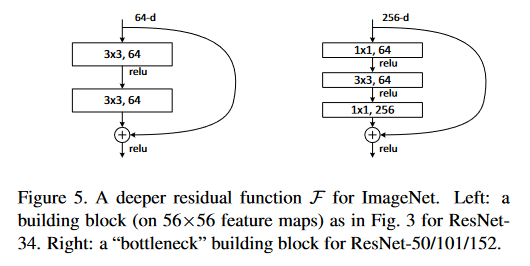

## ResNet architecture:

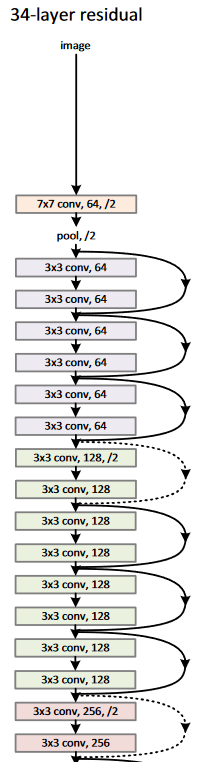
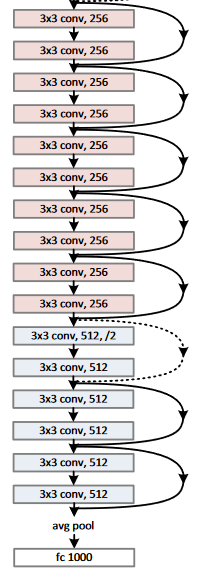

## WideResNet architecture:

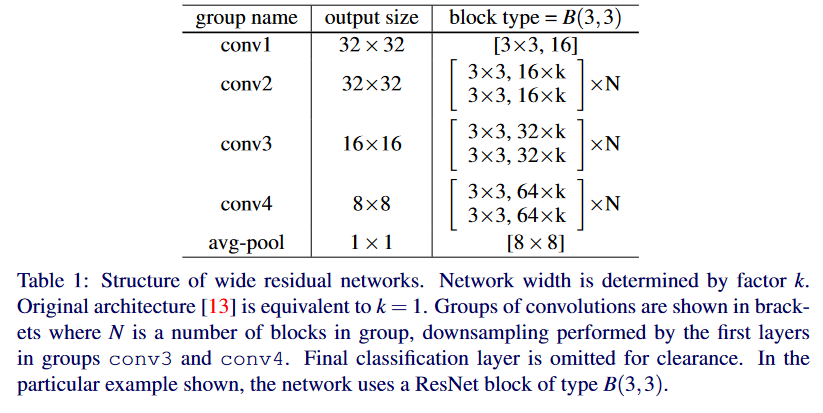
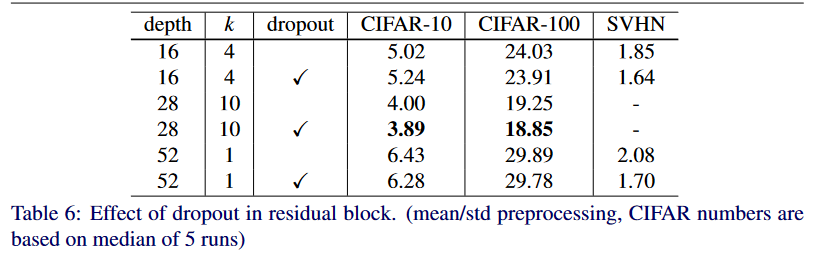
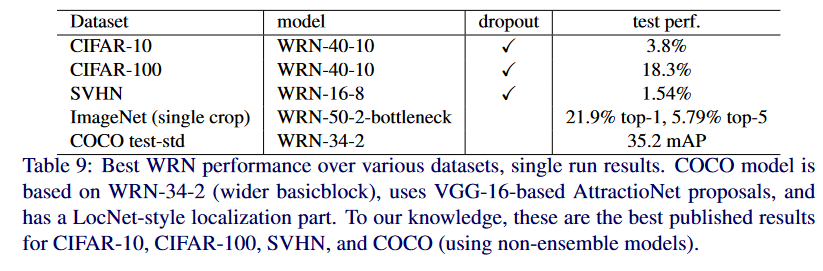

In [13]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, dropout=0):
        # Invoke nn.Module constructor
        super(BasicBlock, self).__init__()
        # First convolution
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        # Second convolution
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.dropout = dropout
        self.is_first_block = (in_channels != out_channels) # Whether it's a first block in a group
        self.dim_handler = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False), # 1x1 convolution
            nn.BatchNorm2d(out_channels)) # batch normalization
        
    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        if self.dropout > 0:
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.conv2(self.relu2(self.bn2(out)))
        
        # If it's a first block in a group we need to handle difference in dimensions
        # between residual connection and output
        return torch.add(self.dim_handler(x) if self.is_first_block else x, out)

class WRNGroup(nn.Module):
    def __init__(self, blocks_num, in_channels, out_channels, stride, dropout=0):
        # Invoke nn.Module constructor
        super(WRNGroup, self).__init__()
        blocks = []
        # Create n blocks, first block has stride possibly != 1
        for i in range(int(blocks_num)):
            blocks.append(BasicBlock(in_channels if i==0 else out_channels, out_channels, stride if i==0 else 1, dropout))
        self.group = nn.Sequential(*blocks)

    def forward(self, x):
        return self.group(x)

class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor=1, dropout=0, num_classes=10):
        # depth = 6*N + 4
        # widen_factor = k
        # Invoke nn.Module constructor
        super(WideResNet, self).__init__()
        channels_num = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        
        assert((depth - 4) % 6 == 0) # Check the corectness of depth
        n = (depth - 4) / 6
        
        # conv1 group
        self.conv1_group = nn.Conv2d(in_channels=3, out_channels=channels_num[0], kernel_size=3, stride=1, padding=1, bias=False)
        # conv2 group
        self.conv2_group = WRNGroup(blocks_num=n, in_channels=channels_num[0], out_channels=channels_num[1], stride=1, dropout=dropout)
        # conv3 group
        self.conv3_group = WRNGroup(blocks_num=n, in_channels=channels_num[1], out_channels=channels_num[2], stride=2, dropout=dropout)
        # conv4 group
        self.conv4_group = WRNGroup(blocks_num=n, in_channels=channels_num[2], out_channels=channels_num[3], stride=2, dropout=dropout)
        
        self.out_channels = channels_num[3]
        
        self.bn = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.out_channels, num_classes),
            nn.Softmax(dim=1))

        # Weights and bias initialization
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                # Kaiming ("He") initialization
                # In 'fan_out' mode, it considers the number of output units (fan-out)
                # when calculating the variance
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu') 
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)  # no scale
                module.bias.data.zero_()  # no shift
            elif isinstance(module, nn.Linear):
                module.bias.data.zero_() # no initial bias
                
    def forward(self, x):
        out = self.conv1_group(x)
        out = self.conv2_group(out)
        out = self.conv3_group(out)
        out = self.conv4_group(out)
        out = self.relu(self.bn(out)) # Add additional BN + ReLU due to the changed order
        out = F.avg_pool2d(out, 8) # We use average pooling [8 x 8]
        out = out.view(-1, self.out_channels)
        out = self.classifier(out)
        
        return out

# Ordinary training with WideResNet and CIFAR-10

In [14]:
# Set up stohastic gradient descent method, WideResNet with:
# learning rate   start=0.1   end=0.05
# momentum = 0.9
# dropout = 0.3
# weight_decay = 0.0001
# n=28, k=10
# For Deep_co_train:
# batch_size = 50   batch_size_S = 15   batch_size_U = 35
# lambda_cot_max = 10   lambda_diff_max = 0.5
wideresnet_nn = WideResNet(depth=28, widen_factor=10, dropout=0.3).to(device)
optimizer = optim.SGD(wideresnet_nn.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
wideresnet_nn_model = OrdinaryTraining(wideresnet_nn, optimizer, criterion, accuracy, 
                                    train_loader, test_loader, device)

Creating OrdinaryTraining model from scratch...
Model successfully created!


In [15]:
# train for 6 epochs
wideresnet_nn_model.train_validate_cycle(epochs=6)

Current epoch: 1
-------
Looked at 22368 samples
Current train loss for batch: 2.139540672302246
Looked at 44768 samples
Current train loss for batch: 2.06296968460083

Average train loss: 2.18541
Average validation loss: 2.13649, Average validation acc: 31.84%


Saving 1 status:'best' checkpoint, current average accuracy: 31.84% is better than previous best result: 0.00%
Successfully saved epoch 1 status:best checkpoint!

Current epoch: 2
-------
Looked at 22368 samples
Current train loss for batch: 2.144719123840332
Looked at 44768 samples
Current train loss for batch: 2.147252321243286

Average train loss: 2.09137
Average validation loss: 2.10788, Average validation acc: 34.31%


Saving 2 status:'best' checkpoint, current average accuracy: 34.31% is better than previous best result: 31.84%
Successfully saved epoch 2 status:best checkpoint!

Current epoch: 3
-------
Looked at 22368 samples
Current train loss for batch: 2.136810541152954
Looked at 44768 samples
Current train loss for 

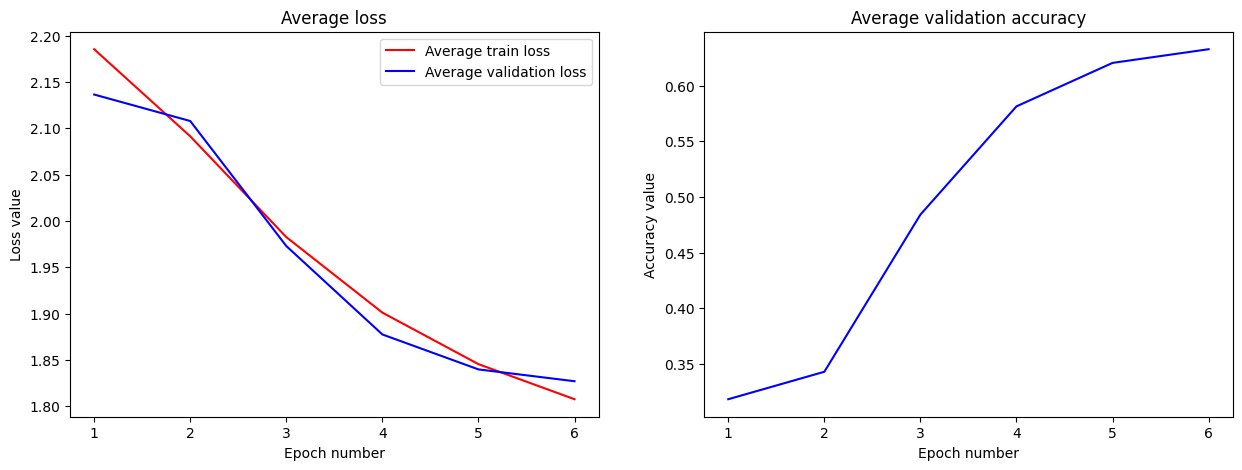

In [18]:
wideresnet_nn_model.plot_loss_acc()

In [19]:
test_loss_score, test_accuracy_score = wideresnet_nn_model.model_test()
print(f"Test loss: {test_loss_score}")
print(f"Test accuracy: {100*test_accuracy_score}%")

Test loss: 1.8269150257110596
Test accuracy: 63.278751373291016%


# Deep-Co-Training with WideResNet and CIFAR-10

In [17]:
wideresnet_nn_model = DeepCoTraining(model=lambda: WideResNet(depth=28, widen_factor=10, dropout=0.3),
                                     optimizer=lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=0.0001),
                                     accuracy=accuracy, 
                                     labelled_trainset=train_labeled_dataset,
                                     unlabelled_trainset=train_unlabeled_dataset,
                                     validset=testset, device=device)

Creating model from scratch...
Model successfully created!


In [18]:
# train for 6 epochs
wideresnet_nn_model.train_validate_cycle(epochs=6)

Current epoch: 1
-------


 40%|████      | 400/1000 [08:26<13:10,  1.32s/it]

Looked at 19950 samples
Current train loss for batch: 4.624351978302002


 80%|████████  | 800/1000 [16:48<04:23,  1.32s/it]

Looked at 39950 samples
Current train loss for batch: 4.610177516937256


100%|██████████| 1000/1000 [20:59<00:00,  1.26s/it]



Average train loss: 4.55083
Average validation acc1: 17.97%
Average validation acc2: 22.13%
Average validation ensemble acc: 21.12%


Saving 1 status:'best' checkpoint, current average accuracy: 20.05% is better than previous best result: 0.00%
Successfully saved epoch 1 status:best checkpoint!

Current epoch: 2
-------


 40%|████      | 400/1000 [08:21<13:11,  1.32s/it]

Looked at 19950 samples
Current train loss for batch: 4.6488237380981445


 80%|████████  | 800/1000 [16:43<04:23,  1.32s/it]

Looked at 39950 samples
Current train loss for batch: 4.461774826049805


100%|██████████| 1000/1000 [20:54<00:00,  1.25s/it]



Average train loss: 4.50298
Average validation acc1: 25.50%
Average validation acc2: 28.02%
Average validation ensemble acc: 28.48%


Saving 2 status:'best' checkpoint, current average accuracy: 26.76% is better than previous best result: 20.05%
Successfully saved epoch 2 status:best checkpoint!

Current epoch: 3
-------


 40%|████      | 400/1000 [08:21<13:11,  1.32s/it]

Looked at 19950 samples
Current train loss for batch: 4.459997177124023


 80%|████████  | 800/1000 [16:43<04:23,  1.32s/it]

Looked at 39950 samples
Current train loss for batch: 4.453282356262207


100%|██████████| 1000/1000 [20:54<00:00,  1.25s/it]



Average train loss: 4.41852
Average validation acc1: 24.51%
Average validation acc2: 30.01%
Average validation ensemble acc: 29.41%


Saving 3 status:'best' checkpoint, current average accuracy: 27.26% is better than previous best result: 26.76%
Successfully saved epoch 3 status:best checkpoint!

Current epoch: 4
-------


 40%|████      | 400/1000 [08:22<13:11,  1.32s/it]

Looked at 19950 samples
Current train loss for batch: 4.256863594055176


 80%|████████  | 800/1000 [16:44<04:23,  1.32s/it]

Looked at 39950 samples
Current train loss for batch: 4.551027297973633


100%|██████████| 1000/1000 [20:55<00:00,  1.26s/it]



Average train loss: 4.35171
Average validation acc1: 31.32%
Average validation acc2: 32.96%
Average validation ensemble acc: 33.25%


Saving 4 status:'best' checkpoint, current average accuracy: 32.14% is better than previous best result: 27.26%
Successfully saved epoch 4 status:best checkpoint!

Current epoch: 5
-------


 40%|████      | 400/1000 [08:22<13:11,  1.32s/it]

Looked at 19950 samples
Current train loss for batch: 4.415964126586914


 80%|████████  | 800/1000 [16:44<04:23,  1.32s/it]

Looked at 39950 samples
Current train loss for batch: 4.164754390716553


100%|██████████| 1000/1000 [20:55<00:00,  1.26s/it]



Average train loss: 4.27559
Average validation acc1: 32.61%
Average validation acc2: 37.01%
Average validation ensemble acc: 36.57%


Saving 5 status:'best' checkpoint, current average accuracy: 34.81% is better than previous best result: 32.14%
Successfully saved epoch 5 status:best checkpoint!

Current epoch: 6
-------


 40%|████      | 400/1000 [08:22<13:11,  1.32s/it]

Looked at 19950 samples
Current train loss for batch: 4.190089225769043


 80%|████████  | 800/1000 [16:44<04:23,  1.32s/it]

Looked at 39950 samples
Current train loss for batch: 4.188110828399658


100%|██████████| 1000/1000 [20:55<00:00,  1.26s/it]



Average train loss: 4.22576
Average validation acc1: 35.97%
Average validation acc2: 38.34%
Average validation ensemble acc: 39.04%


Saving 6 status:'best' checkpoint, current average accuracy: 37.16% is better than previous best result: 34.81%
Successfully saved epoch 6 status:best checkpoint!



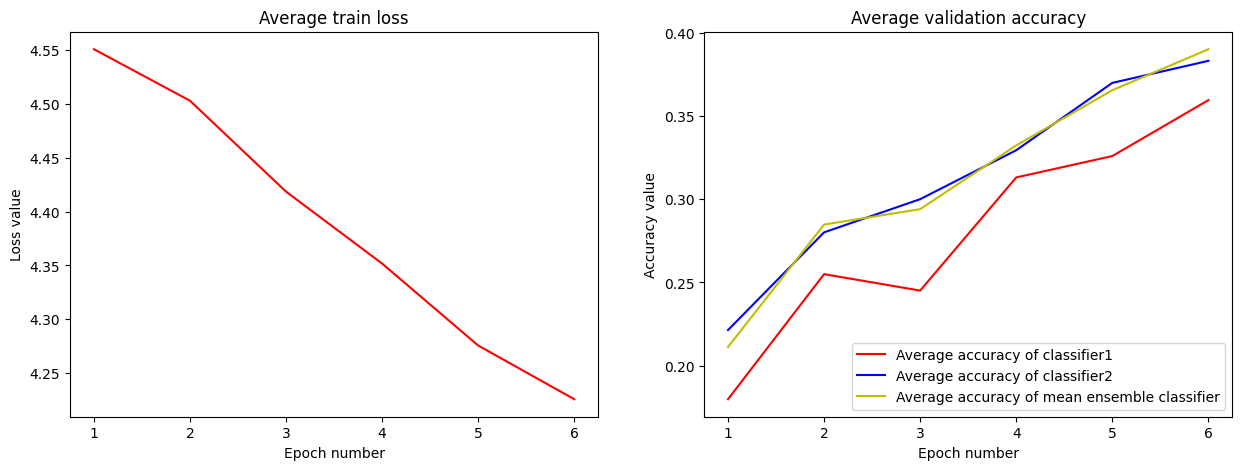

In [19]:
wideresnet_nn_model.plot_loss_acc()

In [20]:
test_accuracy1_score, test_accuracy2_score, test_accuracy_ens_score = wideresnet_nn_model.model_test()
print(f"Test accuracy 1: {100*test_accuracy1_score}%")
print(f"Test accuracy 2: {100*test_accuracy2_score}%")
print(f"Test accuracy ensemble: {100*test_accuracy_ens_score}%")

Test accuracy 1: 35.972442626953125%
Test accuracy 2: 38.33865737915039%
Test accuracy ensemble: 39.037540435791016%


# Results comparison
|   | **Learning algorithm** | Training time | Number of epochs | Best validation accuracy |
|---|------------------------|---------------|------------------|--------------------------|
| 1 | Ordinary               | 21 minute     | 6                | 63.28%                   |
| 2 | Deep-Co-Training       | 2 hours       | 6                | 39.04% (ensemble)        |